In [1]:
import os, sys, glob, json
from itertools import product, compress, chain
from functools import reduce
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
from tools import save_hdf, save_npz, load_npz, PrintAdminUnits, PlotAdminShapes
from tools import FDW_PD_Sweeper, FDW_PD_AvalTable, FDW_PD_Compiling, FDW_PD_GrainTypeAgg, FDW_PD_ValidateFnidName
from tools import FDW_PD_CreateAdminLink, FDW_PD_RatioAdminLink, FDW_PD_ConnectAdminLink
from tools import FDW_PD_CaliSeasonYear
from tools_graphic import PlotBarProduction, PlotLinePAY, PlotHeatCropSystem, PlotHeatSeasonData
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

In [2]:
# CPCV2 grain code ------------------------------ #
grain_code = pd.read_hdf('./data/crop/grain_cpcv2_code.hdf')
product_category = grain_code[['product', 'product_category']].set_index('product').to_dict()['product_category']
# ----------------------------------------------- #

# Load FEWS NET administrative boundaries ------- #
epsg = 'EPSG:32638'
fn_shapes = sorted(glob.glob('./data/shapefile/fewsnet/ET_Admin?_????.shp'))
shape_all = []
for fn in fn_shapes:
    name = fn[-18:-4]
    exec('%s = gpd.read_file("%s").to_crs("%s")' % (name, fn, epsg))
    exec('%s["area"] = %s["geometry"].area/10**6' % (name, name))
    exec('shape_all.append(%s)' % (name))
shape_all = pd.concat(shape_all, axis=0).reset_index(drop=True)
PrintAdminUnits(shape_all)
# ----------------------------------------------- #

# FDW API host address -------------------------- #
host = 'https://fdw.fews.net'
#read in username and password
exec(open('/Users/wanders7/Documents/Code/Logins/FDW.py').read())
auth = (username, password)
parameters = {
    'format': 'json',
    'country': 'Ethiopia',
    'product': 'R011',
    'survey_type': 'crop:best'
}
endpoint = '/api/cropproductionfacts/'
response = requests.get(host + endpoint, auth=auth, params=parameters, proxies={})
response.raise_for_status()
df = pd.DataFrame.from_records(response.json())
df_origin = df.copy()
# ----------------------------------------------- #

- FEWS NET admin shapefiles ------------------- #
| year	 | Admin1   | # units   | Admin2   | # units   |
| 1994	 | ET1994A1 | 11	| ET1994A2	| 66	|
| 2001	 | ET2001A1 | 11	| ET2001A2	| 68	|
| 2003	 | ET2003A1 | 11	| ET2003A2	| 73	|
| 2007	 | ET2007A1 | 11	| ET2007A2	| 75	|
| 2008	 | ET2008A1 | 11	| ET2008A2	| 80	|
| 2014	 | ET2014A1 | 11	| ET2014A2	| 77	|
| 2019	 | ET2019A1 | 11	| ET2019A2	| 84	|
| 2020	 | ET2020A1 | 11	| ET2020A2	| 91	|
| 2021	 | ET2021A1 | 12	| ET2021A2	| 92	|
----------------------------------------------- #


In [3]:
# Manual Pre-processing before Sweeping --------- #
# 1. Default setting
# a.1) None-type crop production system
df.loc[df['crop_production_system'].isna(), 'crop_production_system'] = 'none'
df.loc[df['crop_production_system'] == '', 'crop_production_system'] = 'none'
# a.2) Early in the record the catch-all crop production system is 'all' rather than none. Make these to none-type
df.loc[df['crop_production_system'] == 'all', 'crop_production_system'] = 'none'
# b) None-type population group
df.loc[df['population_group'].isna(), 'population_group'] = 'none'
df.loc[df['population_group'] == '', 'population_group'] = 'none'
# ----------------------------------------------- #
#Drop the hundreds of blank (nan) rows that are duplicates of rows that do have data
df=df[np.isfinite(df.value)]
df=df[df['admin_2'].isna()]
# rows = ['fnid','season_year', 'product','indicator','crop_production_system']
rows = ['fnid','season_year', 'product','indicator','crop_production_system','value','population_group']

toFill = df[df[['fnid','season_year','indicator','crop_production_system','product']].duplicated(keep=False)]# find all duplicates
none_toFill=toFill[toFill['population_group']=='none']
none_toFill_id=none_toFill[['fnid','season_year', 'product','indicator','crop_production_system']]
population_drop=pd.merge(df,none_toFill_id,how='inner',on=['fnid','season_year','indicator', 'product','crop_production_system'])
temp_df=pd.concat([df,population_drop],ignore_index=True,verify_integrity=True,sort=True)
temp_df.drop_duplicates(subset=['fnid','season_year', 'indicator','product','crop_production_system','value'],keep=False,inplace=True)
temp_df_group=temp_df.groupby(by=['fnid','season_year','indicator','crop_production_system','product']).sum()
temp_df_group.reset_index(inplace=True)
temp_pa=temp_df_group.copy(deep=True)
for fnid in temp_pa.fnid.drop_duplicates():
    for season_year in temp_pa[temp_pa['fnid']==fnid].season_year.drop_duplicates():
        for product in temp_pa[(temp_pa['fnid']==fnid)&(temp_pa['season_year']==season_year)]['product'].drop_duplicates():
            temp_pa[(temp_pa['fnid']==fnid)&(temp_pa['season_year']==season_year)&(temp_pa['product']==product)&(temp_pa['indicator']=='Yield')].value= temp_pa[(temp_pa['fnid']==fnid)&(temp_pa['season_year']==season_year)&(temp_pa['product']==product)&(temp_pa['indicator']=='Quantity Produced')].value/temp_pa[(temp_pa['fnid']==fnid)&(temp_pa['season_year']==season_year)&(temp_pa['product']==product)&(temp_pa['indicator']=='Area Planted')].value
# temp_pa['value'].loc[temp_df.indicator=='Yield'] = temp_pa['value'].loc[temp_pa.indicator=='Quantity Produced'].values/temp_pa['value'].loc[temp_pa.indicator=='Area Planted'].values
temp_df_group['value'].loc[temp_df_group.indicator=='Yield'] = temp_pa['value'].loc[temp_df_group.indicator=='Yield']
temp_df_group=temp_df_group[['fnid','season_year','indicator','crop_production_system','product','value']]
temp_df = temp_df.drop(['value'],axis=1)
temp_merge = pd.merge(temp_df,temp_df_group, how='inner',on = ['fnid','season_year','indicator','crop_production_system','product'])

temp_merge.drop_duplicates(subset=['fnid','season_year', 'indicator','product','crop_production_system','value'],keep='first',inplace=True)
df = temp_merge.append(none_toFill)

# FDW Production Data Inspection ---------------- #
df, df_raw = FDW_PD_Sweeper(df)
table_dict = FDW_PD_AvalTable(df, shape_all)
# ----------------------------------------------- #

# # FEWS NET Shapefile comparison ----------------- #
shape_used = pd.concat([ET_Admin1_1994,ET_Admin1_2001,ET_Admin1_2003,ET_Admin1_2007,ET_Admin1_2008,ET_Admin1_2014,ET_Admin1_2019,ET_Admin1_2020,ET_Admin1_2021], axis=0)
PlotAdminShapes(shape_used, label=True)
# # ----------------------------------------------- #

- Remove missing records ---------------------- #
Orignial data points: 1,174
434/434 "Area Planted" points are retained.
373/373 "Quantity Produced" points are retained.
367/367 "Yield" points are retained.
Current data points: 1,174

- Minor changes are applied ------------------- #

- Basic information --------------------------- #
Data period: 1994 - 2017
8 grain types are found: Barley (Unspecified), Maize (Corn), Millet (Finger), Mixed Teff, Oats (Unspecified), Rice (Paddy), Sorghum, Wheat Grain
2 seasons are found: Meher (10-01), Belg (06-01)
1 crop production system are found: none
Data sources include:
[1] Central Statistical Agency, Ethiopia:  --- Agricultural Sample Survey, Ethiopia
[2] Central Statistics Office (CSO), Ethiopia --- Central Statistical Agency, Ethiopia
[3] MOA, Ethiopia --- FAO-WFP, Ethiopia
Administrative-1 fnids: 35
Administrative-2 fnids: 0
0 reporting units are found: 

- Total production over time ------------------ #
season_name            Belg  Meher
 

In [7]:
sorted(list(df_origin['season_year'].unique()))

# Define the latest shapefile ------------------- #
latest_level = 1
shape_latest = ET_Admin1_2014.copy().to_crs('epsg:4326')
# ----------------------------------------------- #

# Validation of FNIDs and Names ----------------- #
df = FDW_PD_ValidateFnidName(df, shape_used, shape_latest)
# ----------------------------------------------- #

# FDW Production Data Compiling ----------------- #
area, prod = FDW_PD_Compiling(df, shape_used)
area_all, prod_all = area.copy(), prod.copy()
mdx_pss = area.columns.droplevel([0,1]).unique()

In [8]:
#  Link admin boundaries ------------------------- #
link_1994, over_1994 = FDW_PD_CreateAdminLink(ET_Admin1_1994, ET_Admin1_2014, 'ADMIN1', 'ADMIN1', prod, epsg)
link_2001, over_2001 = FDW_PD_CreateAdminLink(ET_Admin1_2001, ET_Admin1_2014, 'ADMIN1', 'ADMIN1', prod, epsg)
link_2003, over_2003 = FDW_PD_CreateAdminLink(ET_Admin1_2003, ET_Admin1_2014, 'ADMIN1', 'ADMIN1', prod, epsg)
link_2007, over_2007 = FDW_PD_CreateAdminLink(ET_Admin1_2007, ET_Admin1_2014, 'ADMIN1', 'ADMIN1', prod, epsg)
link_2008, over_2008 = FDW_PD_CreateAdminLink(ET_Admin1_2008, ET_Admin1_2014, 'ADMIN1', 'ADMIN1', prod, epsg)
# link_2014, over_2014 = FDW_PD_CreateAdminLink(ET_Admin1_2014, ET_Admin1_2019, 'ADMIN1', 'ADMIN1', prod, epsg)

# Crop specific ratios
link_ratio_1994 = FDW_PD_RatioAdminLink(link_1994, prod, over_1994, mdx_pss)
link_ratio_2001 = FDW_PD_RatioAdminLink(link_2001, prod, over_2001, mdx_pss)
link_ratio_2003 = FDW_PD_RatioAdminLink(link_2003, prod, over_2003, mdx_pss)
link_ratio_2007 = FDW_PD_RatioAdminLink(link_2007, prod, over_2007, mdx_pss)
link_ratio_2008 = FDW_PD_RatioAdminLink(link_2008, prod, over_2008, mdx_pss)
# link_ratio_2014 = FDW_PD_RatioAdminLink(link_2014, prod, over_2014, mdx_pss)

# Merge link_ratio
assert link_ratio_1994.keys() == link_ratio_2008.keys()
assert link_ratio_2001.keys() == link_ratio_2008.keys()
assert link_ratio_2003.keys() == link_ratio_2008.keys()
assert link_ratio_2007.keys() == link_ratio_2008.keys()
# assert link_ratio_2008.keys() == link_ratio_2008.keys()

link_merged = [link_ratio_1994, link_ratio_2001,link_ratio_2003,link_ratio_2007,link_ratio_2008]
fnids_new = list(link_merged[0].keys())
link_ratio = dict()
for fnid in fnids_new:
    container = []
    for link in link_merged:
        container.append(link[fnid])
    link_ratio[fnid] = pd.concat(container, axis=1)
# Add current unit to link_ratio
for fnid_new in link_ratio.keys():
    link_ratio[fnid_new][fnid_new] = 1.0
    link_ratio[fnid_new] = link_ratio[fnid_new].sort_index(axis=1, ascending=False)
# Connect data with AdminLink
area_new, prod_new = FDW_PD_ConnectAdminLink(link_ratio, area, prod, validation=False)
# ----------------------------------------------- #


CBR is considered for 'ET1994A114' as no record found in: ['ET2014A114']
CBR is considered for 'ET2001A114' as no record found in: ['ET2014A114']
CBR is considered for 'ET2003A114' as no record found in: ['ET2014A114']
CBR is considered for 'ET2007A114' as no record found in: ['ET2014A114']
CBR is considered for 'ET2008A114' as no record found in: ['ET2014A114']


In [9]:
# Manual correction ----------------------------- #
crop_new = prod_new/area_new

# Complete long format DataFrame ---------------- #
df_area = area_new.T.stack().rename('value').reset_index()
df_area['indicator'] = 'area'
df_prod = prod_new.T.stack().rename('value').reset_index()
df_prod['indicator'] = 'production'
df_yield = (prod_new/area_new).T.stack().rename('value').reset_index()
df_yield['indicator'] = 'yield'
stack = pd.concat([df_area, df_prod, df_yield], axis=0)
# Add "growing year"
cols = ['season_name','product','crop_production_system','growing_month','harvest_year','harvest_month','growing_year']
season_table = df[cols].drop_duplicates()
stack = stack.merge(season_table, on=cols[:-1])
# Add country and admin names
stack = stack.merge(df[['fnid','country','country_code','admin_1','admin_2']].drop_duplicates(), on='fnid', how='inner')
names = [
    'fnid','country','country_code','admin_1','admin_2','name',
    'product','season_name','growing_year','growing_month','harvest_year','harvest_month',
    'crop_production_system','indicator','value'
]
stack_gscd = stack[names]
stack_gscd['gscd_code'] = 'calibrated'
# ----------------------------------------------- #
# Reported FDW data ----------------------------- #
stack_fdw = df[names]
stack_fdw['indicator'] = stack_fdw['indicator'].replace({'Area Harvested':'area','Quantity Produced':'production','Yield':'yield'})
stack_fdw['gscd_code'] = 'reported'
# ----------------------------------------------- #
# Final Processing ------------------------------ #
stack = pd.concat([stack_fdw,stack_gscd], axis=0).reset_index(drop=True)
# No concerns found for grain types
stack['product'] = stack['product'].replace(product_category)
# Calibration of Growing and Harvest year and season
cs = {
    'Meher': {'growing_month':{'10-01':'10-01'},'harvest_month':{'01-01':'01-01'}},
    'Belg': {'growing_month': {'10-01': '10-01'}, 'harvest_month': {'01-01': '01-01'}},
}
cy = {}
stack, df, link_ratio = FDW_PD_CaliSeasonYear(stack, df, link_ratio, cs, cy)
stack.loc[stack['admin_1'].isna(), 'admin_1'] = 'none'
stack.loc[stack['admin_2'].isna(), 'admin_2'] = 'none'
# # ----------------------------------------------- #

# Save data
save_hdf('./data/crop/adm_crop_production_ET_admin1.hdf', stack)
save_hdf('./data/crop/adm_crop_production_ET_raw_admin1.hdf', df)
save_npz('./data/crop/adm_crop_production_ET_ratio_admin1.npz', link_ratio)


./data/crop/adm_crop_production_ET_admin1.hdf is saved.
./data/crop/adm_crop_production_ET_raw_admin1.hdf is saved.
./data/crop/adm_crop_production_ET_ratio_admin1.npz is saved.


In [10]:
stack_gscd

fnid   country country_code admin_1 admin_2    name       product  \
0     ET2014A101  Ethiopia           ET  Tigray    None  Tigray       Sorghum   
1     ET2014A101  Ethiopia           ET  Tigray    None  Tigray       Sorghum   
2     ET2014A101  Ethiopia           ET  Tigray    None  Tigray       Sorghum   
3     ET2014A101  Ethiopia           ET  Tigray    None  Tigray       Sorghum   
4     ET2014A101  Ethiopia           ET  Tigray    None  Tigray       Sorghum   
...          ...       ...          ...     ...     ...     ...           ...   
1125  ET2014A113  Ethiopia           ET  Harari    None  Harari  Maize (Corn)   
1126  ET2014A113  Ethiopia           ET  Harari    None  Harari  Maize (Corn)   
1127  ET2014A113  Ethiopia           ET  Harari    None  Harari  Maize (Corn)   
1128  ET2014A113  Ethiopia           ET  Harari    None  Harari       Sorghum   
1129  ET2014A113  Ethiopia           ET  Harari    None  Harari       Sorghum   

     season_name  growing_year growing_month  harvest_year harvest_month  \
0          Meher          1994         10-01          1995         01-01   
1          Meher          1994         10-01          1995         01-01   
2          Meher          1994         10-01          1995         01-01   
3          Meher          1996         10-01          1997         01-01   
4          Meher          1996         10-01          1997         01-01   
...          ...           ...           ...           ...           ...   
1125        Belg          2011         06-01          2011         07-01   
1126        Belg          2011         06-01          2011         07-01   
1127        Belg          2011         06-01          2011         07-01   
1128        Belg          2015         06-01          2015         07-01   
1129        Belg          2016         06-01          2016         07-01   

     crop_production_system   indicator          value   gscd_code  
0                      none        area  222400.000000  calibrated  
1                      none  production  160300.000000  calibrated  
2                      none       yield       0.720773  calibrated  
3                      none        area   96140.000000  calibrated  
4                      none  production  172968.000000  calibrated  
...                     ...         ...            ...         ...  
1125                   none        area     197.930000  calibrated  
1126                   none  production     255.195000  calibrated  
1127                   none       yield       1.289319  calibrated  
1128                   none        area     271.180000  calibrated  
1129                   none        area      99.040000  calibrated  

[1130 rows x 16 columns]

./figures/ET_bar_natgrainprod_Meher.png is saved.


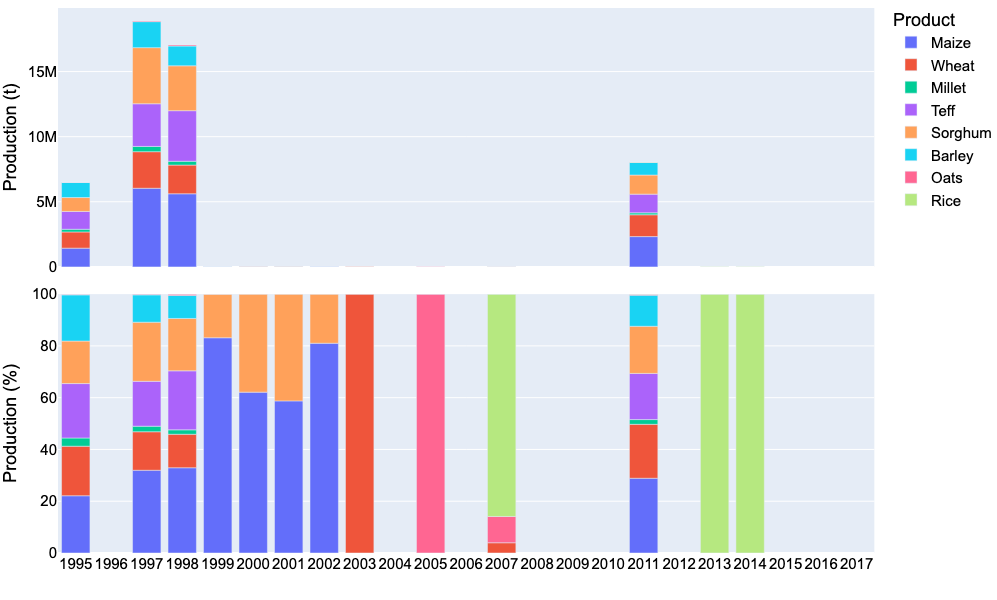

./figures/ET_bar_natgrainprod_Belg.png is saved.


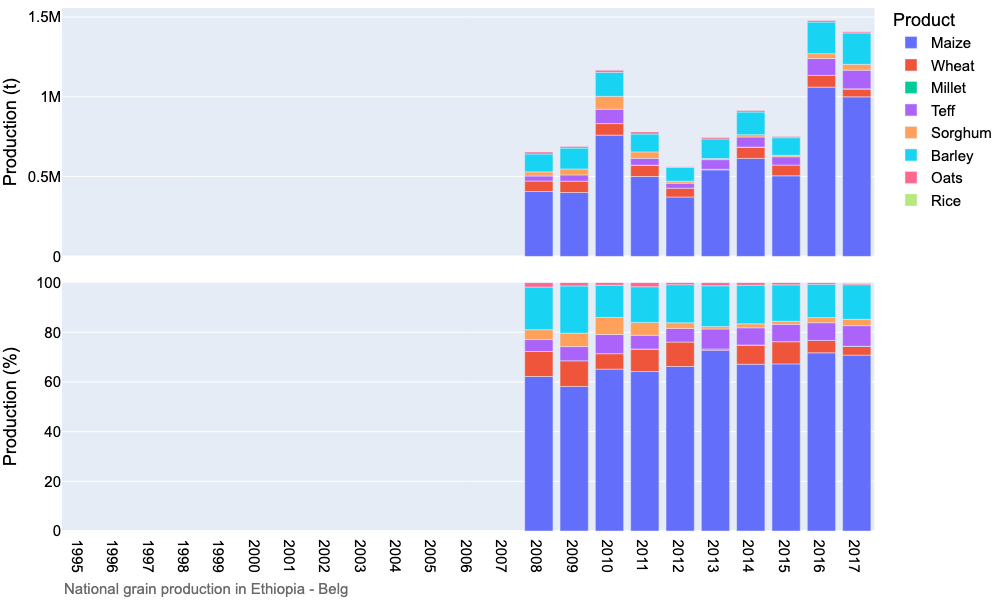

In [11]:
# Bar chart of national grain production
country_iso, country_name = 'ET', 'Ethiopia'
df = pd.read_hdf('./data/crop/adm_crop_production_%s_admin1.hdf' % country_iso)
df = df[df['gscd_code']=='calibrated']; df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
product_order = ['Maize', 'Wheat','Millet', 'Teff','Sorghum','Barley','Oats','Rice']
for season_name in ['Meher','Belg']:
    footnote = 'National grain production in %s - %s' % (country_name, season_name)
    fn_save = './figures/%s_bar_natgrainprod_%s.png' % (country_iso, season_name)
    sub = df[df['season_name'] == season_name]
    fig = PlotBarProduction(sub, year, product_order, footnote, fn_save)
    fig.show()


./figures/ET_line_pay_Barley_Meher.png is saved.


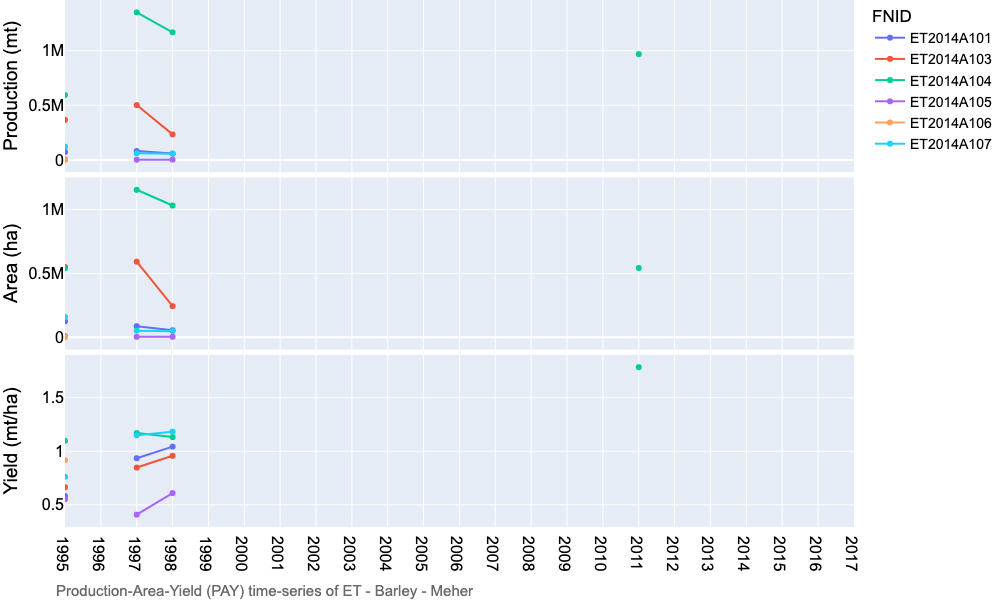

./figures/ET_line_pay_Maize_Meher.png is saved.


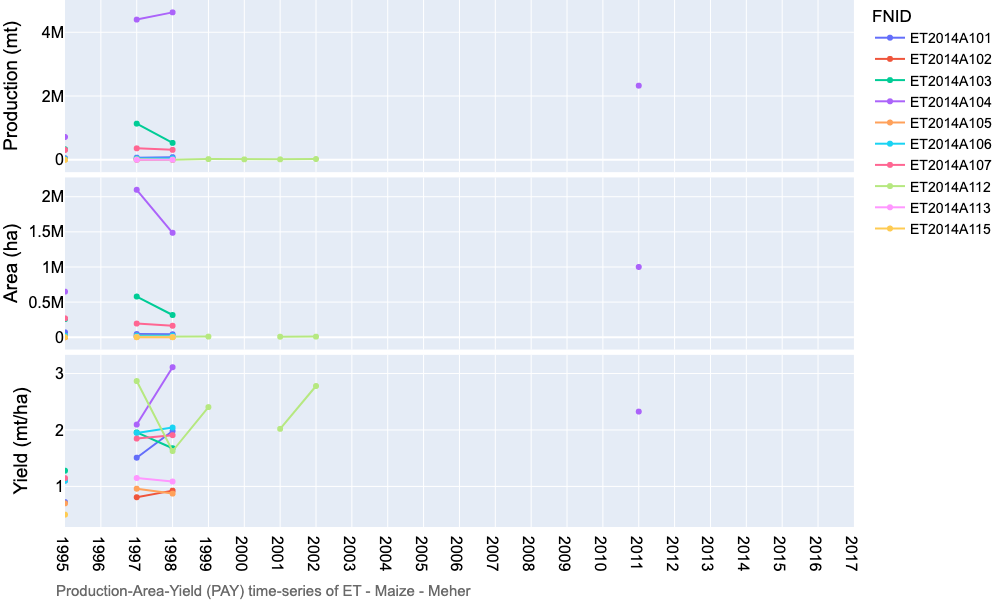

./figures/ET_line_pay_Millet_Meher.png is saved.


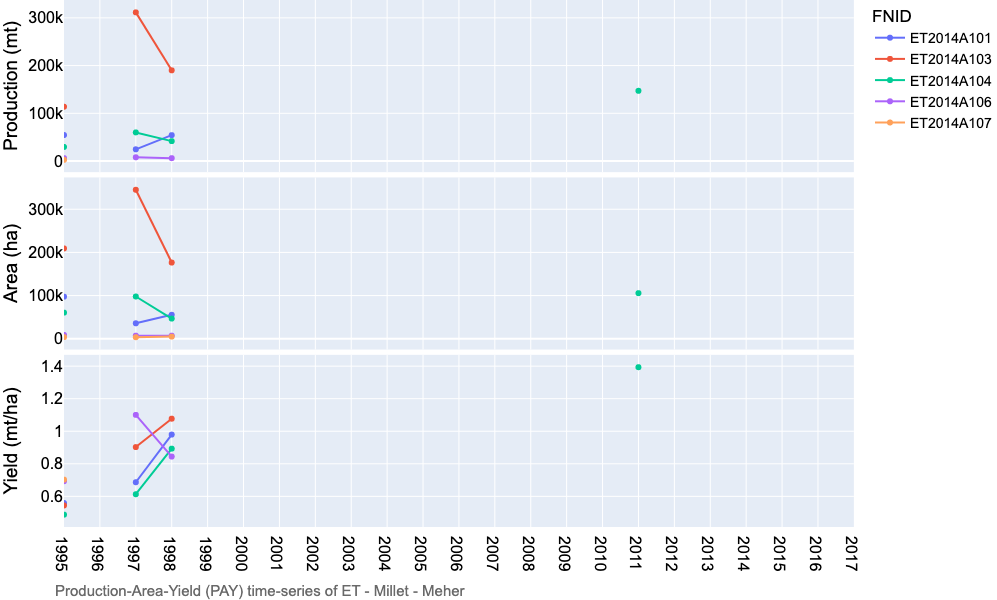

./figures/ET_line_pay_Teff_Meher.png is saved.


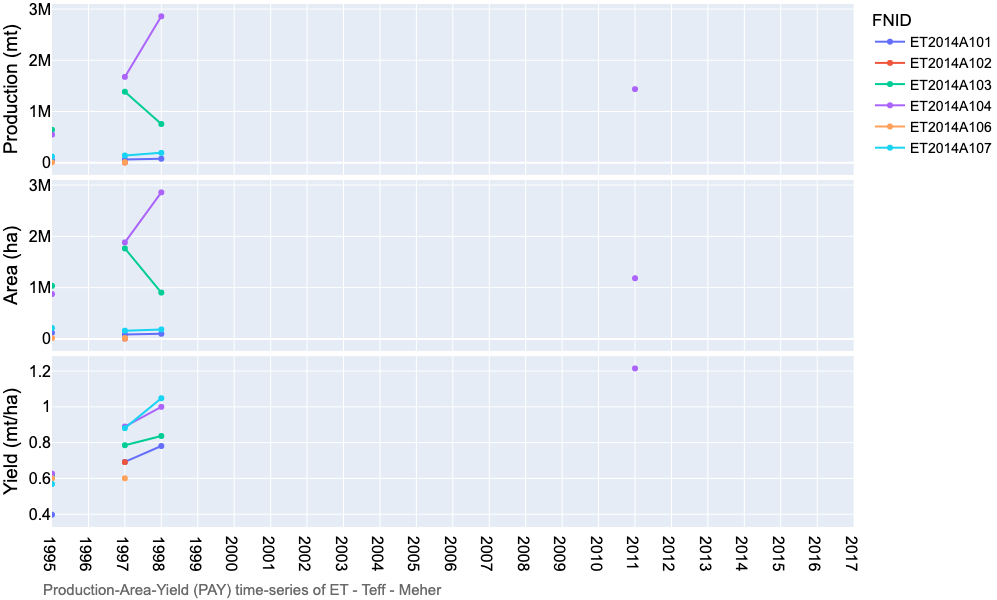

./figures/ET_line_pay_Sorghum_Meher.png is saved.


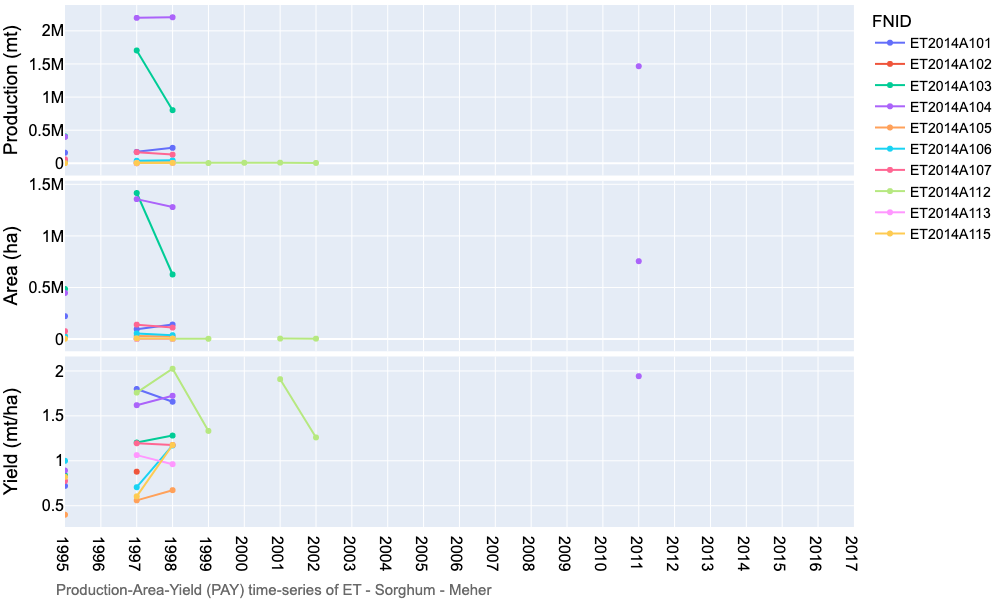

./figures/ET_line_pay_Wheat_Meher.png is saved.


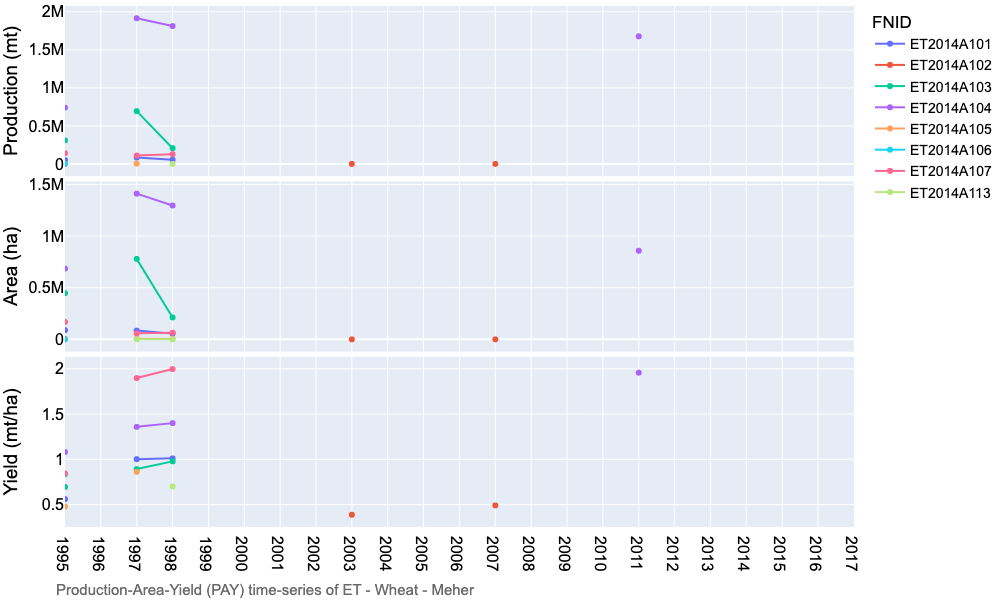

./figures/ET_line_pay_Rice_Meher.png is saved.


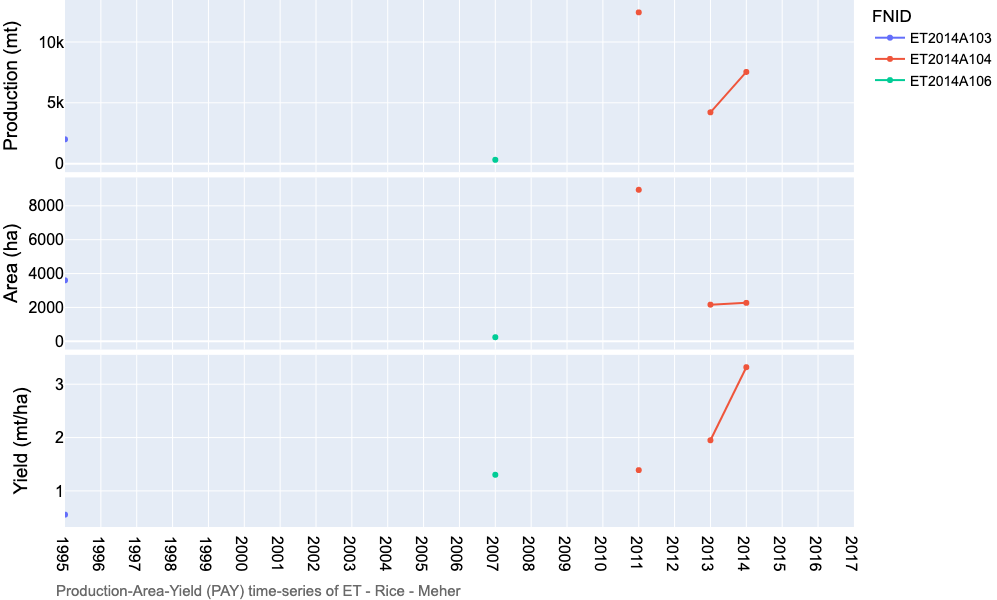

./figures/ET_line_pay_Oats_Meher.png is saved.


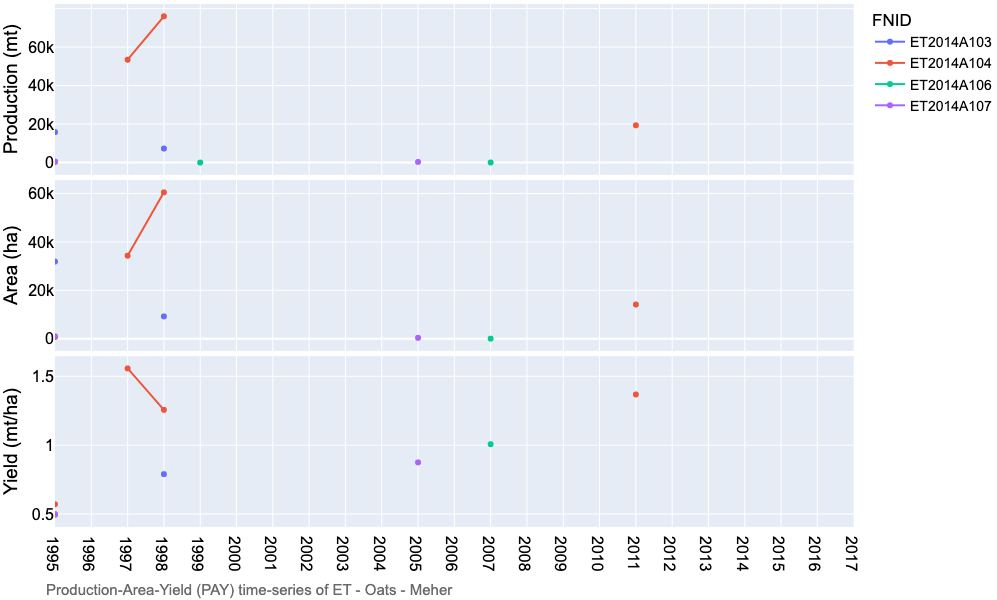

./figures/ET_line_pay_Barley_Belg.png is saved.


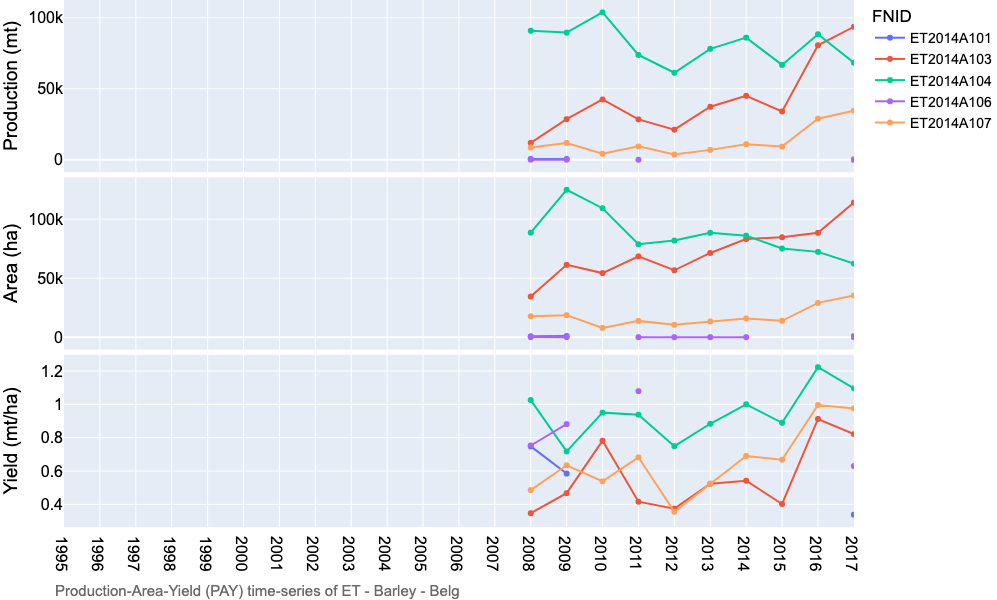

./figures/ET_line_pay_Maize_Belg.png is saved.


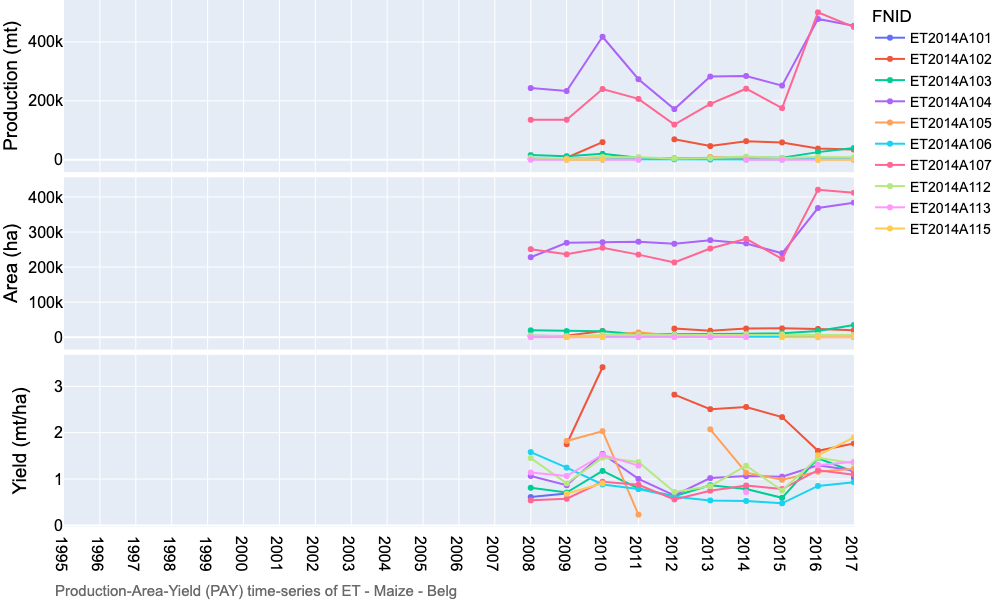

./figures/ET_line_pay_Millet_Belg.png is saved.


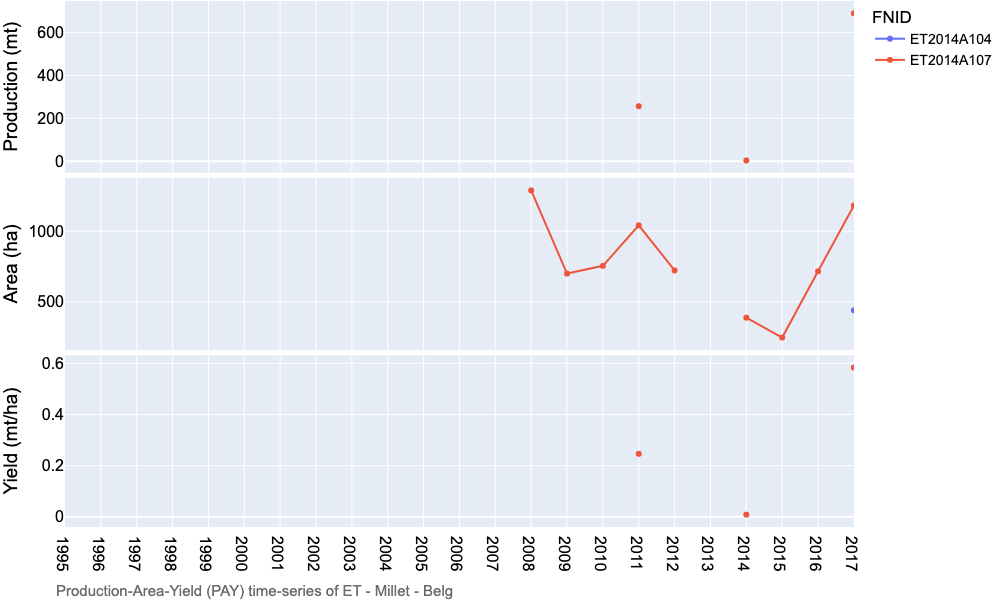

./figures/ET_line_pay_Teff_Belg.png is saved.


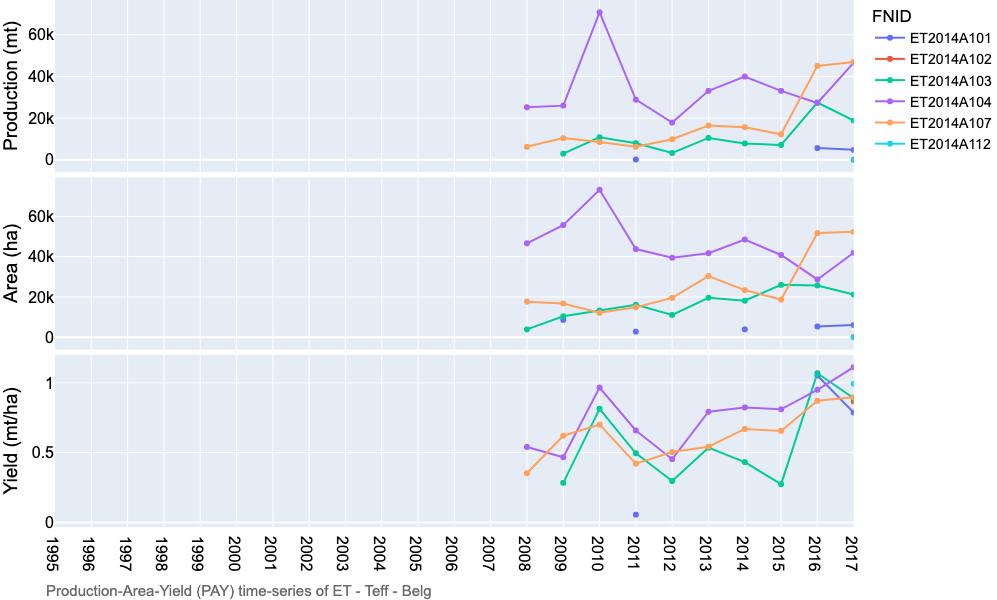

./figures/ET_line_pay_Sorghum_Belg.png is saved.


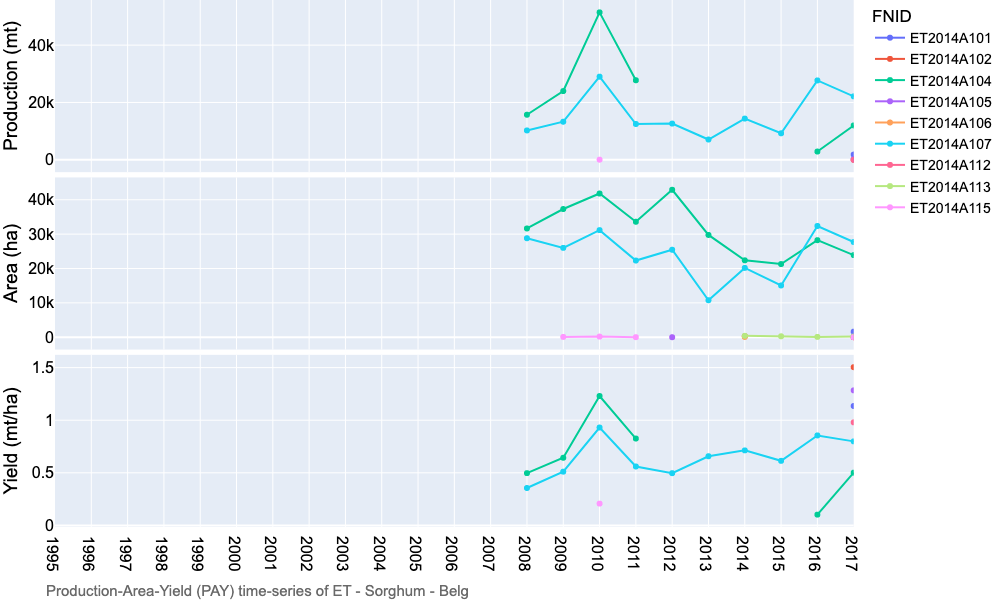

./figures/ET_line_pay_Wheat_Belg.png is saved.


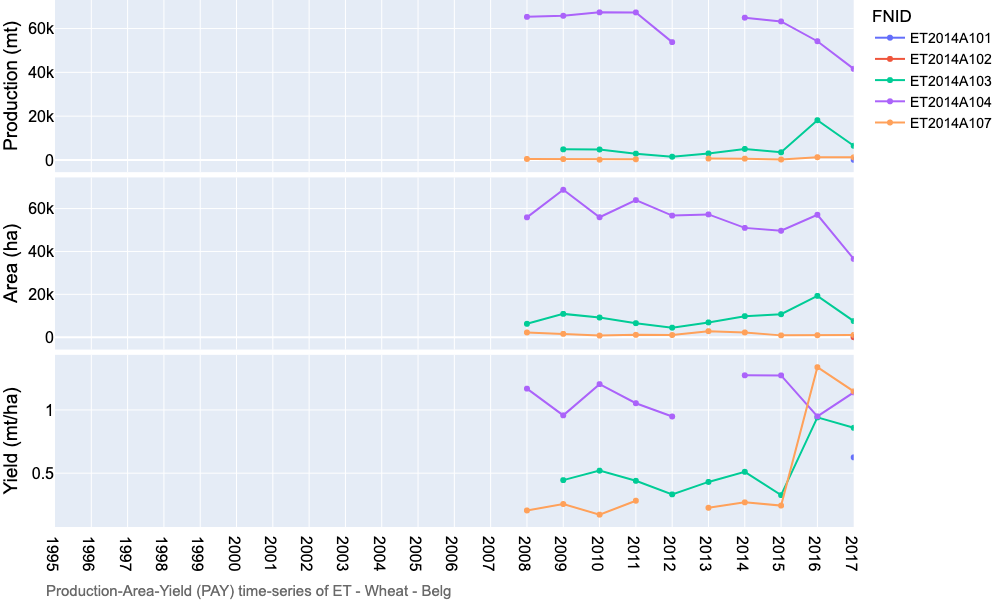

./figures/ET_line_pay_Rice_Belg.png is saved.


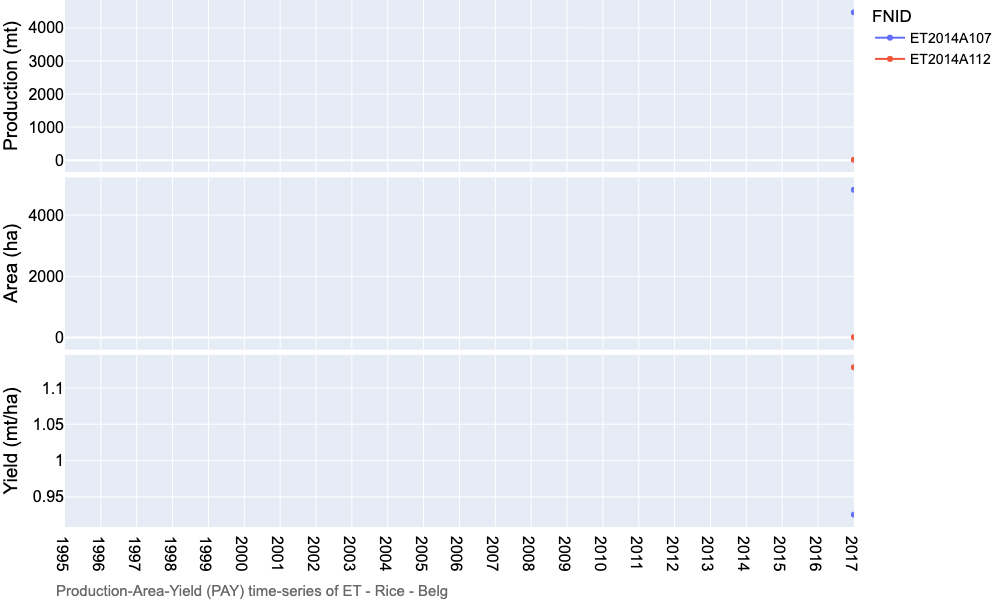

./figures/ET_line_pay_Oats_Belg.png is saved.


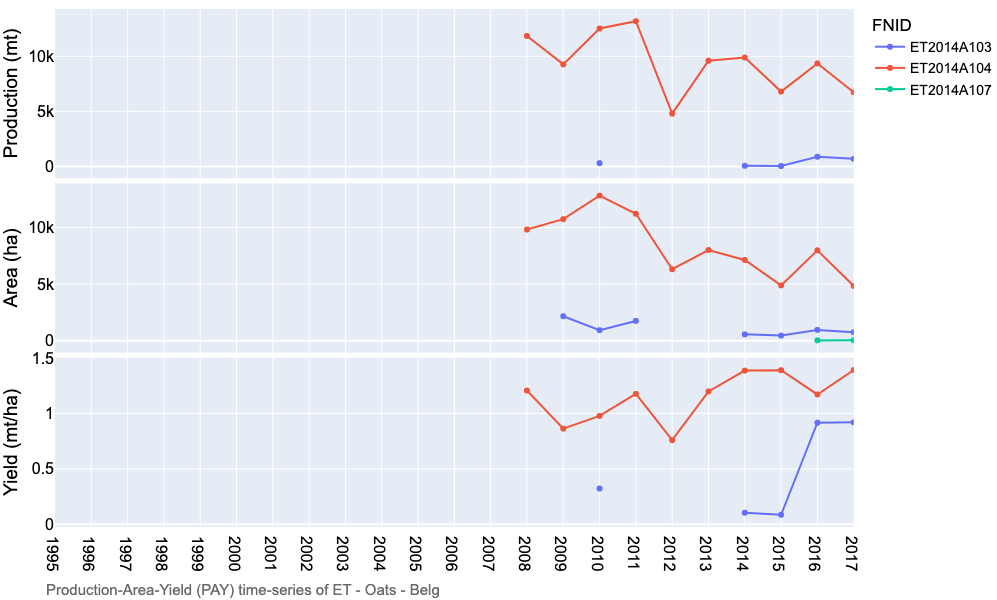

In [12]:
# Lineplot of Production-Area-Yield (PAY) time-series
country_iso, country_name = 'ET', 'Ethiopia'
df = pd.read_hdf('./data/crop/adm_crop_production_%s_admin1.hdf' % country_iso)
df = df[df['gscd_code']=='calibrated']; df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
product_season = [
    ['Barley', 'Meher'],
    ['Maize', 'Meher'],
    ['Millet', 'Meher'],
    ['Teff', 'Meher'],
    ['Sorghum', 'Meher'],
    ['Wheat', 'Meher'],
    ['Rice', 'Meher'],
    ['Oats', 'Meher'],
    ['Barley', 'Belg'],
    ['Maize', 'Belg'],
    ['Millet', 'Belg'],
    ['Teff', 'Belg'],
    ['Sorghum', 'Belg'],
    ['Wheat', 'Belg'],
    ['Rice', 'Belg'],
    ['Oats', 'Belg'],
]
for product_name, season_name in product_season:
    footnote = 'Production-Area-Yield (PAY) time-series of %s - %s - %s' % (country_iso, product_name, season_name)
    fn_save = './figures/%s_line_pay_%s_%s.png' % (country_iso, product_name, season_name)
    sub = df[(df['product'] == product_name) & (df['season_name'] == season_name)]
    fig = PlotLinePAY(sub, year, footnote, fn_save)
    fig.show()


In [14]:
# Calibrated PAY time-series per FNID
from tools_graphic import PlotLineCropTS
country_iso, country_name = 'ET', 'Ethiopia'
df = pd.read_hdf('./data/crop/adm_crop_production_%s_admin1.hdf' % country_iso)
df = df[df['gscd_code']=='calibrated']; df['year'] = df['harvest_year']
link_ratio = load_npz('./data/crop/adm_crop_production_%s_ratio_admin1.npz' % country_iso)
year_all = np.arange(df['year'].min(), df['year'].max()+1)
product_season = [
    ['Barley', 'Meher'],
    ['Maize', 'Meher'],
    ['Millet', 'Meher'],
    ['Teff', 'Meher'],
    ['Sorghum', 'Meher'],
    ['Wheat', 'Meher'],
    ['Rice', 'Meher'],
    ['Oats', 'Meher'],
]
for product_name, season_name in product_season:
    sub = df[
        (df['product'] == product_name) &
        (df['season_name'] == season_name)
    ]
    for fnid in sub['fnid'].unique():
        sub_fps = sub[sub['fnid'] == fnid]
        fn_save = './figures/crop_calibrated/%s_%s_%s_%s.png' % (country_iso, product_name, season_name, fnid)
        fig = PlotLineCropTS(sub_fps, fnid, product_name, season_name, link_ratio, year_all, fn_save)


./figures/crop_calibrated/ET_Barley_Meher_ET2014A101.png is saved.
./figures/crop_calibrated/ET_Barley_Meher_ET2014A103.png is saved.
./figures/crop_calibrated/ET_Barley_Meher_ET2014A104.png is saved.
./figures/crop_calibrated/ET_Barley_Meher_ET2014A105.png is saved.
./figures/crop_calibrated/ET_Barley_Meher_ET2014A106.png is saved.
./figures/crop_calibrated/ET_Barley_Meher_ET2014A107.png is saved.
./figures/crop_calibrated/ET_Maize_Meher_ET2014A101.png is saved.
./figures/crop_calibrated/ET_Maize_Meher_ET2014A102.png is saved.
./figures/crop_calibrated/ET_Maize_Meher_ET2014A103.png is saved.
./figures/crop_calibrated/ET_Maize_Meher_ET2014A104.png is saved.
./figures/crop_calibrated/ET_Maize_Meher_ET2014A105.png is saved.
./figures/crop_calibrated/ET_Maize_Meher_ET2014A106.png is saved.
./figures/crop_calibrated/ET_Maize_Meher_ET2014A107.png is saved.
./figures/crop_calibrated/ET_Maize_Meher_ET2014A115.png is saved.
./figures/crop_calibrated/ET_Maize_Meher_ET2014A112.png is saved.
./fi